In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from scipy.optimize import curve_fit
from scipy import integrate
import matplotlib as mpl

def init_mpl(global_dpi,labelsize = 15.5,legendsize = 11.40, fontsize = 13,mat_settings = False): # 13
    if mat_settings:
        fontsize = 10
        labelsize = 13
    mpl.rcParams['figure.dpi']= global_dpi
    mpl.rc('axes', labelsize=labelsize)
    font = {'size'   : fontsize}#'family' : 'normal', #'weight' : 'bold'
    mpl.rc('font', **font)
    mpl.rc('legend',fontsize = legendsize)

In [2]:
init_mpl(150)

# Functions

In [3]:
def f(x):
    return 0

def special_f(x):
    return np.piecewise(x, [x >= 0 , x >= 1.5, x >=2],
                        [lambda x: 1 - x,lambda x: -0.5+(x-1.5),0])



### Basisfunction times source function
def Bf(x,x1,x2,f,upwards = True):
    if upwards:
        return (x-x1)/(x2-x1)*f(x)
    else:
        return -(x-x2)/(x2-x1)*f(x)
    

### FEM == False ->> Finite difference
def solution(X,f,BC1 = 0, BC2 = 1, e = 1, u = 1, e_bar = 0, FEM = False, Bf = None, SUPG = False):
    A = np.zeros((len(X)-2,len(X)-2))
    f_vec = np.zeros((len(X)-2))
    h = (X[-1]-X[0])/(len(X)-1)
    ##################
    if not SUPG:
        if not FEM:
            e = e+ e_bar
            for i in range(A.shape[0]):
                A[i,i] = 2*e/h**2
                if not i == 0:
                    A[i,i-1] = (-u/(2*h)-e/h**2)
                else:
                    f_vec[i] += -(-u/(2*h)-e/h**2)*BC1
                if not i == A.shape[0]-1:
                    A[i,i+1] = (u/(2*h) - e/h**2)
                else:
                    f_vec[i] += -(u/(2*h)-e/h**2)*BC2

                f_vec[i] += f(X[i+1])
        else: 
            e = e+ e_bar
            for i in range(A.shape[0]):
                A[i,i] = 2*e/h
                if not i == 0:
                    A[i,i-1] = (-u/(2)-e/h)
                else:
                    f_vec[i] += -(-u/(2)-e/h)*BC1
                if not i == A.shape[0]-1:
                    A[i,i+1] = (u/(2) - e/h)
                else:
                    f_vec[i] += -(u/(2)-e/h)*BC2
                f_vec[i] += integrate.quadrature(Bf,X[i],X[i+1],(X[i],X[i+1],f,True))[0]
                f_vec[i] += integrate.quadrature(Bf,X[i+1],X[i+2],(X[i+1],X[i+2],f,True))[0]
    else:
        tau = e_bar/u**2
        e= e+(u**2)*tau
        for i in range(A.shape[0]):
            A[i,i] = 2*e/h
            if not i == 0:
                A[i,i-1] = (-u/(2)-e/h)
            else:
                f_vec[i] += -(-u/(2)-e/h)*BC1
            if not i == A.shape[0]-1:
                A[i,i+1] = (u/(2) - e/h)
            else:
                f_vec[i] += -(u/(2)-e/h)*BC2
            f_vec[i] += integrate.quadrature(Bf,X[i],X[i+1],(X[i],X[i+1],f,True))[0] + tau*u*(1/h)*integrate.quadrature(f,X[i],X[i+1])[0]
            f_vec[i] += integrate.quadrature(Bf,X[i+1],X[i+2],(X[i+1],X[i+2],f,True))[0] -tau*u*(1/h)*integrate.quadrature(f,X[i+1],X[i+2])[0]
    ##############################################
    phi = np.linalg.solve(A,f_vec)
    cache = np.zeros(len(X))
    cache[0] = BC1
    cache[-1] = BC2
    cache[1:-1] = phi
    return cache
    
def analytic(x,e,BC1,BC2):
    pe = 1/e
    res = BC1 + (BC2-BC1)*(np.exp((x-1)*pe) - np.exp(-pe))/(1 - np.exp(-pe))
    return res

# Test $f(x)$

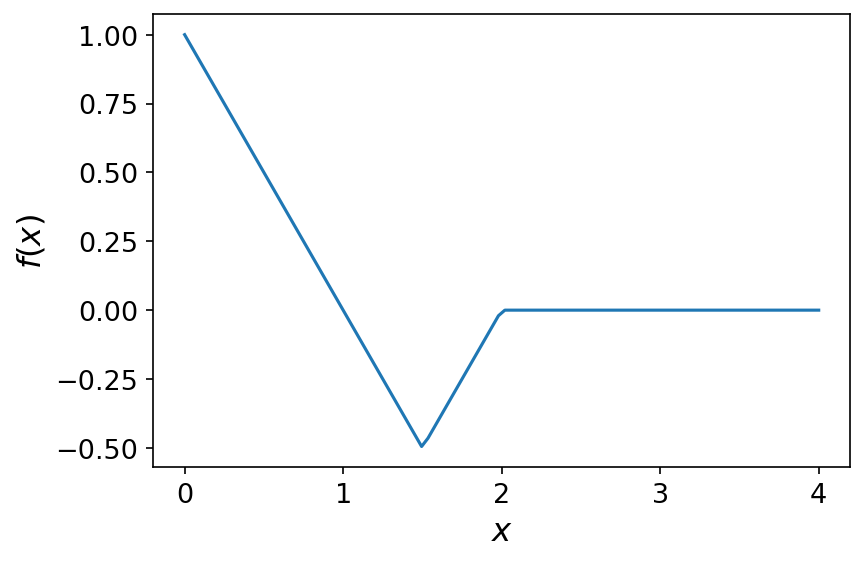

In [4]:
x = np.linspace(0,4,100)
y = special_f(x)
plt.plot(x,y)
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.show()

# Numerical simulations

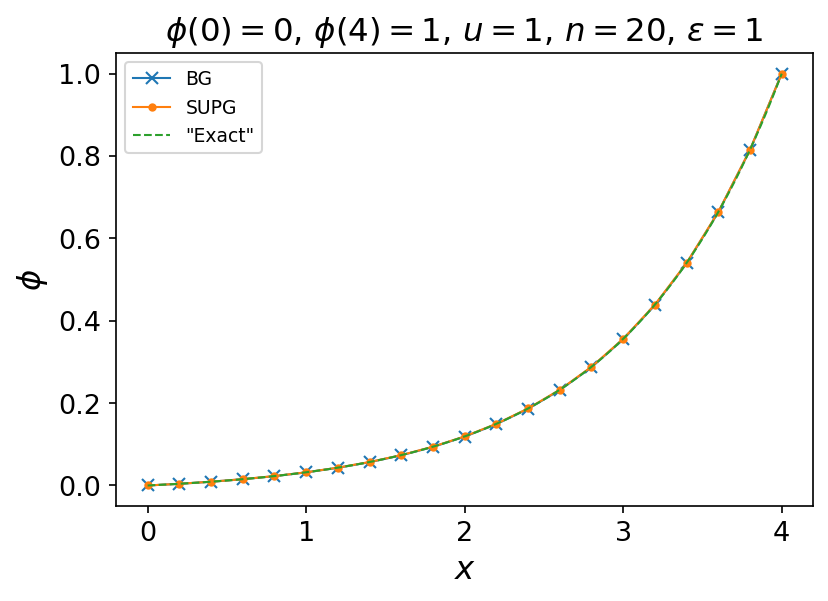

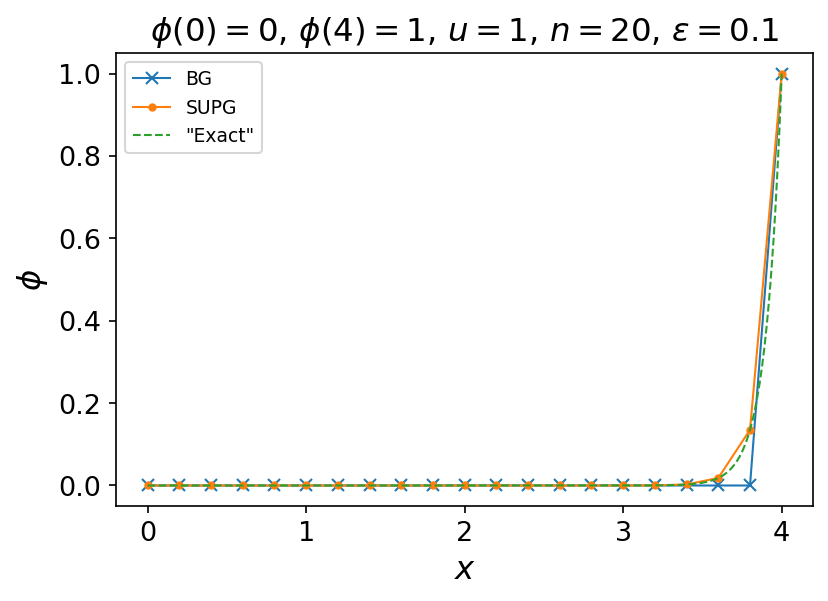

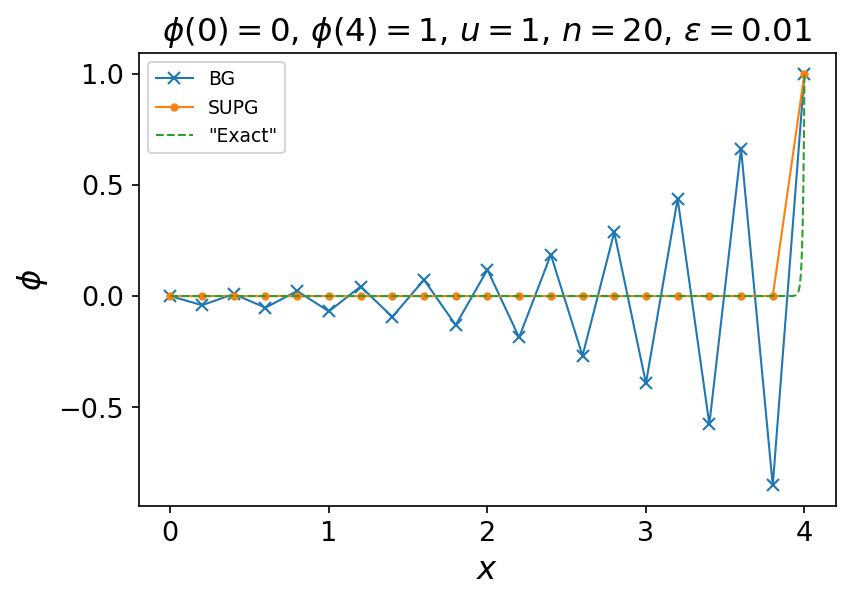

In [5]:
a = 0
b =1
e = 1
u = 1

es = [1,0.1,0.01]
n = 21
X = np.linspace(0,4,n)
phiFEM = []
phiMM = []
phiEx = []
X_ex = np.linspace(0,4,1001)

def e_bar(X,u,e):
    h = X[1]- X[0]
    Pe = np.abs(u)*h/(2*e)
    return np.abs(u)*h/2 *(np.cosh(Pe)/np.sinh(Pe)-1/Pe)


#def e_bar(X,u,e):
#    h = X[1]- X[0]
#    return -e+(h*u/2)*(1+np.exp(u*h/e))/(-1+np.exp(u*h/e))
  



################# f = 0 ###################
for e in es:
    phi = solution(X,f,BC1 = a,BC2 = b,e = e,u = u, FEM =True, Bf = Bf)
    phiFEM.append(phi)
    phi = solution(X,f,BC1 = a,BC2 = b,e = e,u = u, FEM =False, Bf = Bf,e_bar = e_bar(X,u,e))
    phiMM.append(phi)
    phi = solution(X_ex,f,BC1 = a,BC2 = b,e = e,u = u, FEM =True, Bf = Bf)
    phiEx.append(phi)

counter = 0
for i,j,k,e in zip(phiFEM,phiMM,phiEx,es):
    plt.plot(X,i,label = 'BG',marker = 'x',linewidth = 1)
    plt.plot(X,j,label = 'SUPG',marker = '.' ,linewidth = 1)
    plt.plot(X_ex,k,label = '"Exact"', linestyle = '--',linewidth = 1)
    counter += 1
    plt.xlabel('$x$')
    plt.ylabel('$\phi$')
    plt.legend(fontsize = 9)
    plt.title('$\phi(0) = ' + str(a) + '$, $ \phi(4) = ' + str(b) + '$, $u=' + str(u) + ' $, $n = '+str(n-1)+'$, $\epsilon = ' + str(e) + '$')
    plt.show()





/home/toby/anaconda3/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:247: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.970318e-06
  AccuracyWarning)
/home/toby/anaconda3/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:247: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.940635e-06
  AccuracyWarning)


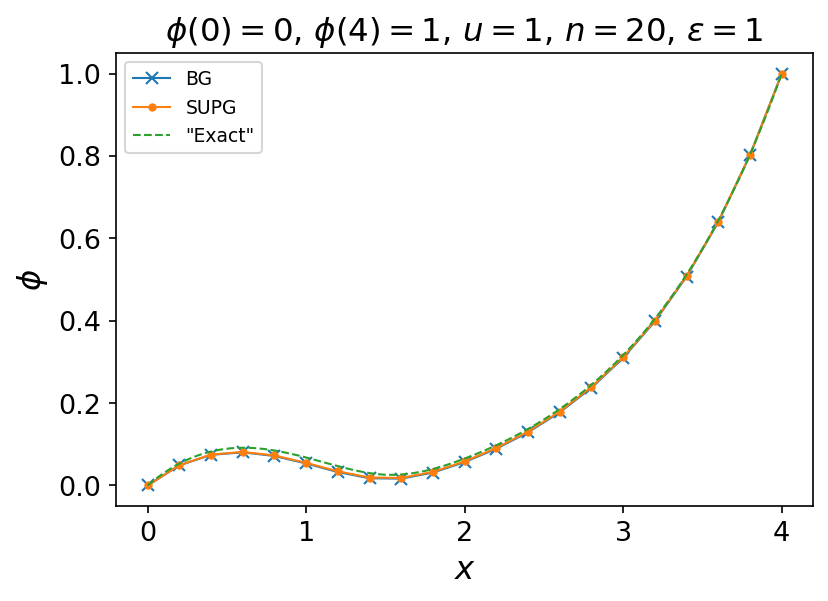

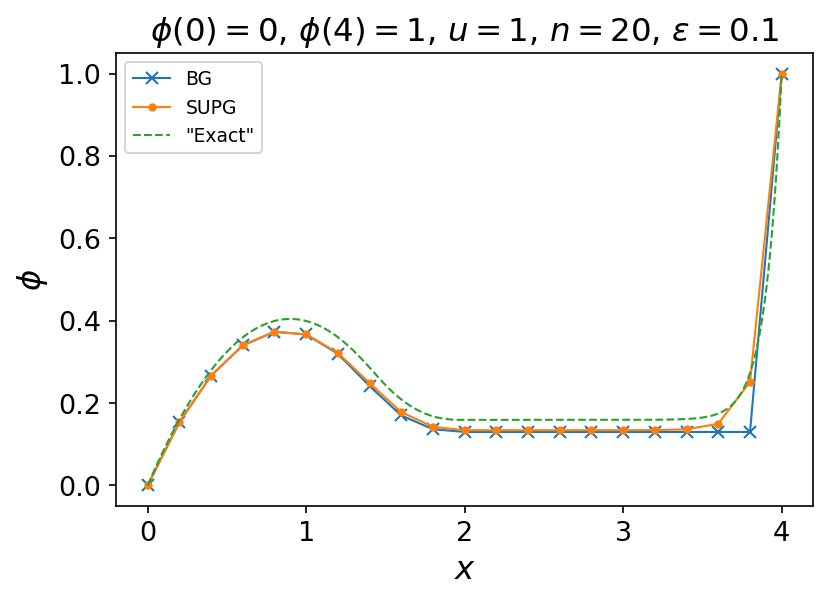

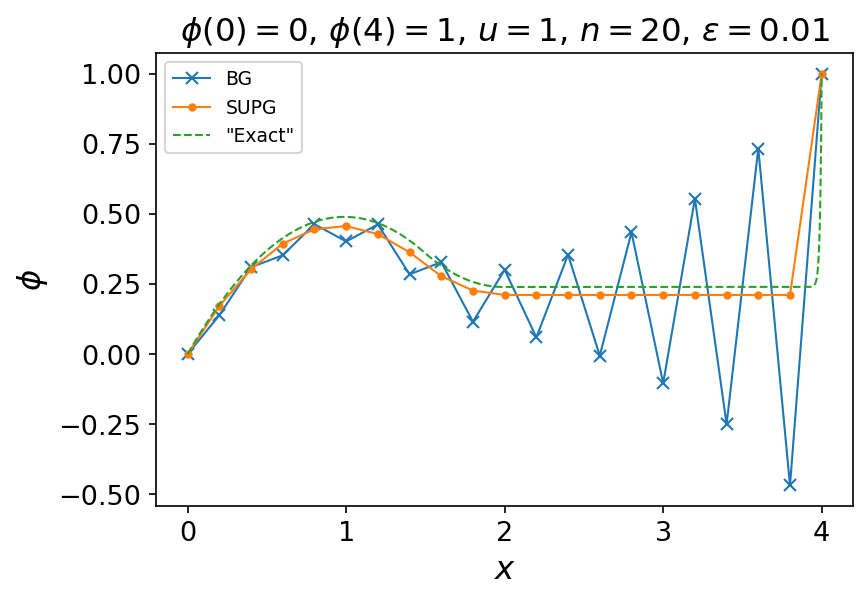

In [6]:
a = 0
b =1
e = 1
u = 1

es = [1,0.1,0.01]
n = 21
X = np.linspace(0,4,n)
phiFEM = []
phiMM = []
phiEx = []
X_ex = np.linspace(0,4,1001)

################ special f ###################
for e in es:
    phi = solution(X,special_f,BC1 = a,BC2 = b,e = e,u = u, FEM =True, Bf = Bf)
    phiFEM.append(phi)
    phi = solution(X,special_f,BC1 = a,BC2 = b,e = e,u = u, FEM =False, Bf = Bf,e_bar = e_bar(X,u,e),SUPG = True)
    phiMM.append(phi)
    phi = solution(X_ex,special_f,BC1 = a,BC2 = b,e = e,u = u, FEM =True, Bf = Bf)
    phiEx.append(phi)

counter = 0
for i,j,k,e in zip(phiFEM,phiMM,phiEx,es):
    plt.plot(X,i,label = 'BG',marker = 'x',linewidth = 1)
    plt.plot(X,j,label = 'SUPG',marker = '.' ,linewidth = 1)
    plt.plot(X_ex,k,label = '"Exact"', linestyle = '--',linewidth = 1)
    counter += 1
    plt.xlabel('$x$')
    plt.ylabel('$\phi$')
    plt.legend(fontsize = 9)
    plt.title('$\phi(0) = ' + str(a) + '$, $ \phi(4) = ' + str(b) + '$, $u=' + str(u) + ' $, $n = '+str(n-1)+'$, $\epsilon = ' + str(e) + '$')
    plt.show()
